In [1]:
%%time
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.style.use('seaborn-dark')

Wall time: 2.19 s


### Function to read and clean the data

In [2]:
def read_data(csv, header=None):
    df = pd.read_csv(csv, header=header)
    df.rename(columns={0:'X', 1:'Y'}, inplace=True)
    df['Xr'] = df['X'].apply(lambda x: x-df['X'].min())
    df['Yr'] = df['Y'].apply(lambda x: x-df['Y'].min())
    df_ = pd.DataFrame()
    df_['xr'] = df['Xr']
    df_['yr'] = -df['Yr']
    return df_

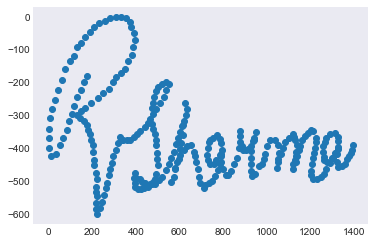

In [3]:
df_ = read_data('rv.txt')
plt.plot(df_['xr'], df_['yr'], 'o')

#### Calculating points for the curve

In [4]:
# find the a & b points
def get_bezier_coef(points):
    # since the formulas work given that we have n+1 points
    # then n must be this:
    n = len(points) - 1

    # build coefficents matrix
    C = 4 * np.identity(n)
    np.fill_diagonal(C[1:], 1)
    np.fill_diagonal(C[:, 1:], 1)
    C[0, 0] = 2
    C[n - 1, n - 1] = 7
    C[n - 1, n - 2] = 2

    # build points vector
    P = [2 * (2 * points[i] + points[i + 1]) for i in range(n)]
    P[0] = points[0] + 2 * points[1]
    P[n - 1] = 8 * points[n - 1] + points[n]

    # solve system, find a & b
    A = np.linalg.solve(C, P)
    B = [0] * n
    for i in range(n - 1):
        B[i] = 2 * points[i + 1] - A[i + 1]
    B[n - 1] = (A[n - 1] + points[n]) / 2

    return A, B

# returns the general Bezier cubic formula given 4 control points
def get_cubic(a, b, c, d):
    return lambda t: np.power(1 - t, 3) * a + 3 * np.power(1 - t, 2) * t * b + 3 * (1 - t) * np.power(t, 2) * c + np.power(t, 3) * d

# return one cubic curve for each consecutive points
def get_bezier_cubic(points):
    A, B = get_bezier_coef(points)
    return [
        get_cubic(points[i], A[i], B[i], points[i + 1])
        for i in range(len(points) - 1)
    ]

# evalute each cubic curve on the range [0, 1] sliced in n points
def evaluate_bezier(points, n):
    curves = get_bezier_cubic(points)
    return np.array([fun(t) for fun in curves for t in np.linspace(0, 1, n)])

#### Fitting the points and drawing the curve

In [5]:
points = np.array(df_[['xr' ,'yr']])

# fit the points with Bezier interpolation
# use 5 points between each consecutive points to draw the curve
path1 = evaluate_bezier(points, 5)

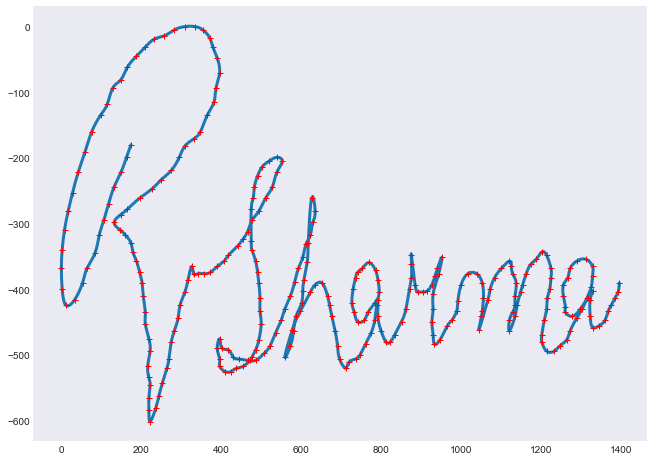

In [6]:
# extract x & y coordinates of points
x, y = points[:,0], points[:,1]
px, py = path1[:,0], path1[:,1]

# plot
plt.figure(figsize=(11, 8))
plt.plot(px, py, linewidth=3)
plt.plot(x, y, 'r+')
plt.show()

### Animation

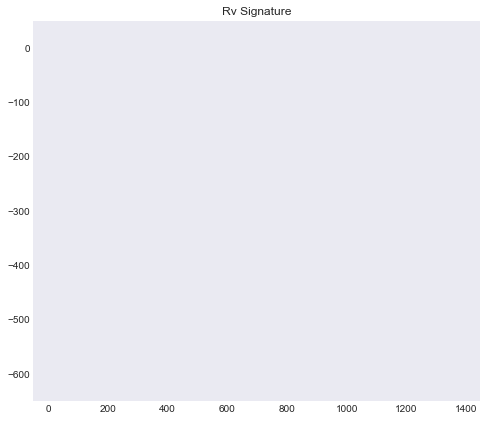

In [7]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set(xlim=(-50, x.max()+50), ylim=(y.min()-50,50))
ax.set_title('Rv Signature')
ax.grid(False)
line, = ax.plot([], [], linewidth=3.5)

In [8]:
from IPython.display import HTML

In [9]:
def animate(i):
    line.set_data(px[:i], py[:i])
    return line,

In [10]:
anim = FuncAnimation(fig, animate, frames=len(px)+1, interval=5.5, blit=True)

In [11]:
%%time
HTML(anim.to_html5_video())

Wall time: 2min 7s


<a href = "https://towardsdatascience.com/b%C3%A9zier-interpolation-8033e9a262c2">Article!</a><br>
<a href = "https://mathworld.wolfram.com/CubicSpline.html">Cubic Spline Wolfram Alpha</a><br>
<a href="https://www.mobilefish.com/services/record_mouse_coordinates/record_mouse_coordinates.php">Get the coordinates!</a><br>
<a href = "https://github.com/d3/d3-shape#curves"> D3 shapes curves </a><br>
<a href = "https://pomax.github.io/bezierinfo/"> All about Beizer curves </a>